In [1]:
import tensorflow as tf
import keras
from kerastuner import GridSearch
from kerastuner import RandomSearch
from kerastuner import Objective
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Activation, Flatten
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
print(tf.config.list_physical_devices('GPU'))

C:\Users\proxr\AppData\Local\Temp\ipykernel_19104\2521440560.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import GridSearch


[]


### 1 Import der Daten

In [28]:
cardiovascular_data = pd.read_csv("ukbiobankdata.csv")
cardiovascular_data

,Age,Sex,SBP,Cholesterol,HDL,LDL,SmokingStatus,DateOfFirstAttendance,f.42000.0.0,f.42006.0.0
0,49,F,110.0,4.295,NaN,2.463,Never,2008-02-25,NaN,NaN
1,69,F,140.0,NaN,NaN,NaN,Never,2009-04-25,NaN,NaN
2,65,F,187.0,6.515,1.546,4.115,Never,2009-05-27,NaN,NaN
3,64,M,138.0,6.633,1.239,4.336,Previous,2009-06-26,2015-07-10,NaN
4,45,F,105.0,5.034,2.292,2.655,Never,2009-11-09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
477569,68,M,202.0,5.241,1.054,3.467,Never,2008-08-28,NaN,2011-12-11
477570,58,F,123.0,5.894,1.651,3.085,Previous,2008-10-11,NaN,NaN
477571,50,M,125.0,3.497,0.901,2.269,Never,2009-11-26,2004-06-30,NaN
477572,58,M,143.0,5.217,0.914,3.232,Previous,2010-03-09,NaN,NaN


### 2 Preprocessing


#### 2.1 Anpassung der SmokingStatus Kategorie

In [29]:
cardiovascular_data["SmokingStatus"].replace(["Current", "Previous"], 1, inplace=True)
cardiovascular_data["SmokingStatus"].replace("Never", 0, inplace=True)

#### 2.2 Einführung einer neuen Spalte "DateOfCardiovascularEvent"

"DateOfCardiovasularEvent" enthält das Datum des Hirninfarkt oder Herzinfarkts eines Patienten. Falls dieser kein kardiovaskuläres Ereignis hatte, hat der Patient den Wert NaN

Konversion in ein Datetimeobjekt, um die Daten miteinander vergleichen zu können

In [30]:
cardiovascular_data["f.42000.0.0"] = pd.to_datetime(cardiovascular_data["f.42000.0.0"], format="%Y-%m-%d")
cardiovascular_data["f.42006.0.0"] = pd.to_datetime(cardiovascular_data["f.42006.0.0"], format="%Y-%m-%d")
cardiovascular_data.dtypes

Age                               int64
Sex                              object
SBP                             float64
Cholesterol                     float64
HDL                             float64
LDL                             float64
SmokingStatus                   float64
DateOfFirstAttendance            object
f.42000.0.0              datetime64[ns]
f.42006.0.0              datetime64[ns]
dtype: object

In [31]:
cardiovascular_data["DateOfCardiovascularEvent"] = np.nan

In [32]:
cardiovascular_data["DateOfCardiovascularEvent"] = pd.to_datetime(cardiovascular_data["DateOfCardiovascularEvent"], format="%Y-%m-%d")

In [1]:
# Sucht für jeden Patienten das frühere Datum heraus, falls ein Patient sowohl Herz- als auch Hininfarkt hatte.
for i in range(len(cardiovascular_data)):
    if(pd.isnull(cardiovascular_data.loc[i, "f.42000.0.0"]) and pd.isnull(cardiovascular_data.loc[i, "f.42006.0.0"])):
        if(cardiovascular_data.loc[i, "f.42000.0.0"] < cardiovascular_data.loc[i, "f.42006.0.0"]):
            cardiovascular_data.loc[i, "DateOfCardiovascularEvent"] = cardiovascular_data.loc[i, "f.42000.0.0"]
        else:
            cardiovascular_data.loc[i, "DateOfCardiovascularEvent"] = cardiovascular_data.loc[i, "f.42006.0.0"]
    if(pd.isnull(cardiovascular_data.loc[i,"f.42000.0.0"]) and not pd.isnull(cardiovascular_data.loc[i, "f.42006.0.0"])):
        cardiovascular_data.loc[i, "DateOfCardiovascularEvent"] = cardiovascular_data.loc[i, "f.42006.0.0"]
    else:
        cardiovascular_data.loc[i, "DateOfCardiovascularEvent"] = cardiovascular_data.loc[i, "f.42000.0.0"]

NameError: name 'cardiovascular_data' is not defined

In [34]:
cardiovascular_data

,Age,Sex,SBP,Cholesterol,HDL,LDL,SmokingStatus,DateOfFirstAttendance,f.42000.0.0,f.42006.0.0,DateOfCardiovascularEvent
0,49,F,110.0,4.295,NaN,2.463,0.0,2008-02-25,NaT,NaT,NaT
1,69,F,140.0,NaN,NaN,NaN,0.0,2009-04-25,NaT,NaT,NaT
2,65,F,187.0,6.515,1.546,4.115,0.0,2009-05-27,NaT,NaT,NaT
3,64,M,138.0,6.633,1.239,4.336,1.0,2009-06-26,2015-07-10,NaT,2015-07-10
4,45,F,105.0,5.034,2.292,2.655,0.0,2009-11-09,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...
477569,68,M,202.0,5.241,1.054,3.467,0.0,2008-08-28,NaT,2011-12-11,2011-12-11
477570,58,F,123.0,5.894,1.651,3.085,1.0,2008-10-11,NaT,NaT,NaT
477571,50,M,125.0,3.497,0.901,2.269,0.0,2009-11-26,2004-06-30,NaT,2004-06-30
477572,58,M,143.0,5.217,0.914,3.232,1.0,2010-03-09,NaT,NaT,NaT


Tests um zu überprüfen, ob die übertragenen Werte stimmen:

In [35]:
print("Anzahl aller Daten aus beiden Spalten: ", cardiovascular_data["f.42000.0.0"].count() + cardiovascular_data["f.42006.0.0"].count())
print("Anzahl aller Daten aus der neuen Spalte: ", cardiovascular_data["DateOfCardiovascularEvent"].count())
count = 0
for i in range(len(cardiovascular_data)):
    if(not pd.isnull(cardiovascular_data.loc[i, "f.42000.0.0"]) and not pd.isnull(cardiovascular_data.loc[i, "f.42006.0.0"])):
        count+= 1
print("Anzahl aller Daten die in beiden Spalten vorkommen: ", count)

Anzahl aller Daten aus beiden Spalten:  47554
Anzahl aller Daten aus der neuen Spalte:  44279
Anzahl aller Daten die in beiden Spalten vorkommen:  3275


Entfernung der Herz- und Hirninfarktspalten, da diese nun nicht mehr gebraucht werden:

In [36]:
cardiovascular_data.drop(["f.42000.0.0", "f.42006.0.0"], axis=1, inplace=True)
cardiovascular_data

,Age,Sex,SBP,Cholesterol,HDL,LDL,SmokingStatus,DateOfFirstAttendance,DateOfCardiovascularEvent
0,49,F,110.0,4.295,NaN,2.463,0.0,2008-02-25,NaT
1,69,F,140.0,NaN,NaN,NaN,0.0,2009-04-25,NaT
2,65,F,187.0,6.515,1.546,4.115,0.0,2009-05-27,NaT
3,64,M,138.0,6.633,1.239,4.336,1.0,2009-06-26,2015-07-10
4,45,F,105.0,5.034,2.292,2.655,0.0,2009-11-09,NaT
...,...,...,...,...,...,...,...,...,...
477569,68,M,202.0,5.241,1.054,3.467,0.0,2008-08-28,2011-12-11
477570,58,F,123.0,5.894,1.651,3.085,1.0,2008-10-11,NaT
477571,50,M,125.0,3.497,0.901,2.269,0.0,2009-11-26,2004-06-30
477572,58,M,143.0,5.217,0.914,3.232,1.0,2010-03-09,NaT


In [37]:
cardiovascular_data["DateOfFirstAttendance"].isna().sum()

1

Es existiert ein Patient, der kein Datum zur Baselineuntersuchung hat. Dieser muss entsprechend entfernt werden. 

In [38]:
cardiovascular_data.dropna(subset=["DateOfFirstAttendance"], inplace=True)

Umwandlung der Spalte DateOfFirstAttendance in ein datetime Objekt, um die Daten miteinander vergleichen zu können.

In [39]:
cardiovascular_data["DateOfFirstAttendance"] = pd.to_datetime(cardiovascular_data["DateOfFirstAttendance"], format="%Y-%m-%d")

#### 2.3 Entfernung aller Patienten, die ein kardiovaskuläres Ereignis vor der Baseline-Untersuchung hatten

In [40]:
for i in range(len(cardiovascular_data)):
    if(not pd.isnull(cardiovascular_data.loc[i, "DateOfFirstAttendance"]) and not pd.isnull(cardiovascular_data.loc[i, "DateOfCardiovascularEvent"])):
        if(cardiovascular_data.loc[i, "DateOfFirstAttendance"] > cardiovascular_data.loc[i, "DateOfCardiovascularEvent"]):
            cardiovascular_data.drop(i, inplace=True)

In [41]:
cardiovascular_data

,Age,Sex,SBP,Cholesterol,HDL,LDL,SmokingStatus,DateOfFirstAttendance,DateOfCardiovascularEvent
0,49,F,110.0,4.295,NaN,2.463,0.0,2008-02-25,NaT
1,69,F,140.0,NaN,NaN,NaN,0.0,2009-04-25,NaT
2,65,F,187.0,6.515,1.546,4.115,0.0,2009-05-27,NaT
3,64,M,138.0,6.633,1.239,4.336,1.0,2009-06-26,2015-07-10
4,45,F,105.0,5.034,2.292,2.655,0.0,2009-11-09,NaT
...,...,...,...,...,...,...,...,...,...
477567,45,F,152.0,5.994,1.243,4.057,0.0,2009-12-09,NaT
477568,58,M,126.0,4.493,1.018,2.733,1.0,2008-03-14,NaT
477569,68,M,202.0,5.241,1.054,3.467,0.0,2008-08-28,2011-12-11
477570,58,F,123.0,5.894,1.651,3.085,1.0,2008-10-11,NaT


#### 2.4 Entfernung aller unvollständigen Patienten

In [42]:
cardiovascular_data.dropna(subset=["Age", "Sex", "SBP", "Cholesterol", "HDL", "LDL", "SmokingStatus"], inplace=True)

In [43]:
cardiovascular_data

,Age,Sex,SBP,Cholesterol,HDL,LDL,SmokingStatus,DateOfFirstAttendance,DateOfCardiovascularEvent
2,65,F,187.0,6.515,1.546,4.115,0.0,2009-05-27,NaT
3,64,M,138.0,6.633,1.239,4.336,1.0,2009-06-26,2015-07-10
4,45,F,105.0,5.034,2.292,2.655,0.0,2009-11-09,NaT
5,57,M,126.0,5.678,1.125,3.912,1.0,2008-09-26,NaT
6,66,F,115.0,5.095,2.296,2.359,1.0,2010-06-30,NaT
...,...,...,...,...,...,...,...,...,...
477567,45,F,152.0,5.994,1.243,4.057,0.0,2009-12-09,NaT
477568,58,M,126.0,4.493,1.018,2.733,1.0,2008-03-14,NaT
477569,68,M,202.0,5.241,1.054,3.467,0.0,2008-08-28,2011-12-11
477570,58,F,123.0,5.894,1.651,3.085,1.0,2008-10-11,NaT


#### 2.5 Umwandlung des Datums in eine Klasse für das neuronale Netz

Zuerst wird für jeden Patient die Jahre von der Baselineuntersuchung bis zu einem möglichen Infarkt berechnet. Die Spalte wird dabei mit dem Wert 100 aufgefüllt, um später die Patienten ohne Herzinfarkt einfach ersetzen zu können.

In [44]:
cardiovascular_data["diff_in_days"] = 0
cardiovascular_data["diff_in_years"] = 100 

In [45]:
cardiovascular_data.reset_index(inplace=True, drop=True)

In [46]:
for i in range(len(cardiovascular_data)):
    if(not pd.isnull(cardiovascular_data.loc[i, "DateOfFirstAttendance"]) and not pd.isnull(cardiovascular_data.loc[i, "DateOfCardiovascularEvent"])):
        cardiovascular_data.loc[i, "diff_in_days"] = cardiovascular_data.loc[i, "DateOfCardiovascularEvent"] - cardiovascular_data.loc[i, "DateOfFirstAttendance"]
        cardiovascular_data.loc[i, "diff_in_years"] = cardiovascular_data.loc[i, "diff_in_days"] / timedelta(days=365)

In [47]:
cardiovascular_data.drop(["diff_in_days"], axis=1, inplace=True)

In [48]:
cardiovascular_data

,Age,Sex,SBP,Cholesterol,HDL,LDL,SmokingStatus,DateOfFirstAttendance,DateOfCardiovascularEvent,diff_in_years
0,65,F,187.0,6.515,1.546,4.115,0.0,2009-05-27,NaT,100.000000
1,64,M,138.0,6.633,1.239,4.336,1.0,2009-06-26,2015-07-10,6.041096
2,45,F,105.0,5.034,2.292,2.655,0.0,2009-11-09,NaT,100.000000
3,57,M,126.0,5.678,1.125,3.912,1.0,2008-09-26,NaT,100.000000
4,66,F,115.0,5.095,2.296,2.359,1.0,2010-06-30,NaT,100.000000
...,...,...,...,...,...,...,...,...,...,...
393713,45,F,152.0,5.994,1.243,4.057,0.0,2009-12-09,NaT,100.000000
393714,58,M,126.0,4.493,1.018,2.733,1.0,2008-03-14,NaT,100.000000
393715,68,M,202.0,5.241,1.054,3.467,0.0,2008-08-28,2011-12-11,3.287671
393716,58,F,123.0,5.894,1.651,3.085,1.0,2008-10-11,NaT,100.000000


Klasse 0: Hat nicht 10 Jahre ohne kardiovaskulären Ereignis überstanden.
Klasse 1: Hat über 10 Jahre ohne kardiovaskulären Ereignis überstanden.

In [50]:
cardiovascular_data["diff_in_years"].replace(100, 11, inplace=True)
cardiovascular_data.loc[cardiovascular_data.diff_in_years < 10, "diff_in_years"] = 0
cardiovascular_data.loc[cardiovascular_data.diff_in_years >= 10, "diff_in_years"] = 1
cardiovascular_data.drop(["DateOfFirstAttendance", "DateOfCardiovascularEvent"], axis=1, inplace=True)
cardiovascular_data.rename(columns={"diff_in_years" : "TenYearSurvival"}, inplace=True)

Aktuelle Klassenverteilung:

In [51]:
cardiovascular_data.TenYearSurvival.value_counts()

1.0    379416
0.0     14302
Name: TenYearSurvival, dtype: int64

Export in eine csv-Datei, damit man die gereinigten Daten bei Wiederverwendung einfach einlesen kann:

In [52]:
cardiovascular_data.reset_index(inplace=True, drop=True)

In [53]:
cardiovascular_data.to_csv("cardiovascular_data_cleaned.csv")

### 3 Verarbeitung der Datentypen in passende Formate zur Verwendung im Neuronalen Netz

In [5]:
cardiovascular_data_cleaned = pd.read_csv("cardiovascular_data_cleaned.csv", usecols=["Age", "Sex", "SBP", "Cholesterol", "HDL", "LDL", "SmokingStatus", "TenYearSurvival"])
cardiovascular_data_cleaned
cardiovascular_data_cleaned.head().to_latex("cvd.tex")

C:\Users\proxr\AppData\Local\Temp\ipykernel_19104\3801726749.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  cardiovascular_data_cleaned.head().to_latex("cvd.tex")


#### 3.1 Klassenverteilung ausgleichen

In [6]:
cardiovascular_data_cleaned["TenYearSurvival"].value_counts()
print(cardiovascular_data_cleaned["TenYearSurvival"].value_counts()[0] / (cardiovascular_data_cleaned["TenYearSurvival"].value_counts()[0] + cardiovascular_data_cleaned["TenYearSurvival"].value_counts()[1]))

0.03632549184949634


In [7]:
def class_distribution(data, distribution):
    upper_class = data[data["TenYearSurvival"] == 1]
    lower_class = data[data["TenYearSurvival"] == 0]
    lower_count = len(lower_class)
    class_diss = int(distribution / (1-distribution) * lower_count)
    
    class_balance = upper_class.sample(n=class_diss, random_state=42)

    new_data = pd.concat([lower_class, class_balance])
    return new_data

##### 3.1.1 Klassenverteilung 50/50

In [8]:
cvd_50 = class_distribution(cardiovascular_data_cleaned, 0.5)
print(cvd_50["TenYearSurvival"].value_counts()[0] / (cvd_50["TenYearSurvival"].value_counts()[0] + cvd_50["TenYearSurvival"].value_counts()[1]))

0.5


##### 3.1.2 Klassenverteilung 60/40

In [9]:
cvd_60 = class_distribution(cardiovascular_data_cleaned, 0.6)
print(cvd_60["TenYearSurvival"].value_counts()[0] / (cvd_60["TenYearSurvival"].value_counts()[0] + cvd_60["TenYearSurvival"].value_counts()[1]))

0.40001118755943393


##### 3.1.3 Klassenverteilung 70/30

In [10]:
cvd_70 = class_distribution(cardiovascular_data_cleaned, 0.7)
print(cvd_70["TenYearSurvival"].value_counts()[0] / (cvd_70["TenYearSurvival"].value_counts()[0] + cvd_70["TenYearSurvival"].value_counts()[1]))

0.3000020976233927


##### 3.1.4 Klassenverteilung 80/20

In [11]:
cvd_80 = class_distribution(cardiovascular_data_cleaned, 0.8)
print(cvd_80["TenYearSurvival"].value_counts()[0] / (cvd_80["TenYearSurvival"].value_counts()[0] + cvd_80["TenYearSurvival"].value_counts()[1]))

0.2


##### 3.1.5 Klassenverteilung 90/10

In [12]:
cvd_90 = class_distribution(cardiovascular_data_cleaned, 0.9)
print(cvd_90["TenYearSurvival"].value_counts()[0] / (cvd_90["TenYearSurvival"].value_counts()[0] + cvd_90["TenYearSurvival"].value_counts()[1]))

0.1


##### 3.1.6 Klassenverteilung 95/10

In [13]:
cvd_95 = class_distribution(cardiovascular_data_cleaned, 0.95)
print(cvd_95["TenYearSurvival"].value_counts()[0] / (cvd_95["TenYearSurvival"].value_counts()[0] + cvd_95["TenYearSurvival"].value_counts()[1]))

0.05000017480133828


#### 3.2 Split von Männern und Frauen

In [14]:
cvd_men = cardiovascular_data_cleaned[cardiovascular_data_cleaned["Sex"] == "M"]
cvd_women = cardiovascular_data_cleaned[cardiovascular_data_cleaned["Sex"] == "F"] 

#### 3.2 One-Hot-Encoding

Da das Netzwerk keine kategorischen Variablen verarbeiten kann, müssen diese umgewandelt werden. Um keine künstliche Reihenfolge zu erzeugen, wird One-Hot-Encoding verwendet.

In [15]:
def do_onehot(df):
    dummy_df = pd.get_dummies(df["Sex"], prefix="Sex")
    df = pd.concat([df, dummy_df], axis=1)
    df.drop(["Sex"], axis=1, inplace=True)

    dummy_df = pd.get_dummies(df["SmokingStatus"], prefix="SmokingStatus")
    df = pd.concat([df, dummy_df], axis=1)
    df.drop(["SmokingStatus"], axis=1, inplace=True)

    return df

In [16]:
cvd_50 = do_onehot(cvd_50)
cvd_60 = do_onehot(cvd_60)
cvd_70 = do_onehot(cvd_70)
cvd_80 = do_onehot(cvd_80)
cvd_90 = do_onehot(cvd_90)
cvd_95 = do_onehot(cvd_95)
cardiovascular_data_cleaned = do_onehot(cardiovascular_data_cleaned)
cvd_men = do_onehot(cvd_men)
cvd_women = do_onehot(cvd_women)

In [17]:
one_hot_latex = cardiovascular_data_cleaned.head().to_latex("onehot.tex")

C:\Users\proxr\AppData\Local\Temp\ipykernel_19104\3768162206.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  one_hot_latex = cardiovascular_data_cleaned.head().to_latex("onehot.tex")


#### 3.3 Normalisierung

In [18]:
def do_scaling(df, target=["Age", "SBP", "Cholesterol", "HDL", "LDL"]):
    scaler = MinMaxScaler()
    df[["Age", "SBP", "Cholesterol", "HDL", "LDL"]] = scaler.fit_transform(df[["Age", "SBP", "Cholesterol", "HDL", "LDL"]])
    return df

In [19]:
do_scaling(cvd_50)
do_scaling(cvd_60)
do_scaling(cvd_70)
do_scaling(cvd_80)
do_scaling(cvd_90)
do_scaling(cvd_95)
cardiovascular_data_cleaned = do_scaling(cardiovascular_data_cleaned)
cvd_men = do_scaling(cvd_men, target=["SBP", "Cholesterol", "HDL", "LDL"])
cvd_women = do_scaling(cvd_women, target=["SBP", "Cholesterol", "HDL", "LDL"])

In [20]:
norm_to_latex = cardiovascular_data_cleaned.head().to_latex("norm.tex")

C:\Users\proxr\AppData\Local\Temp\ipykernel_19104\3526144693.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  norm_to_latex = cardiovascular_data_cleaned.head().to_latex("norm.tex")


### 4 Erstellung des Neuronalen Netzes

#### 4.1 Train-Test-Split der Daten

##### 4.1.1 Split cvd_50

In [21]:
X_50 = cvd_50[["Age", "SBP", "Cholesterol", "HDL", "LDL", "Sex_F", "Sex_M", "SmokingStatus_0.0", "SmokingStatus_1.0"]].copy()
y_50 = cvd_50["TenYearSurvival"]
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X_50, y_50, test_size=0.2, random_state=1)
X_train_50, X_val_50, y_train_50, y_val_50 = train_test_split(X_train_50, y_train_50, test_size=0.25, random_state=1)

##### 4.1.2 Split cvd_60

In [53]:
X_60 = cvd_60[["Age", "SBP", "Cholesterol", "HDL", "LDL", "Sex_F", "Sex_M", "SmokingStatus_0.0", "SmokingStatus_1.0"]].copy()
y_60 = cvd_60["TenYearSurvival"]
X_train_60, X_test_60, y_train_60, y_test_60 = train_test_split(X_60, y_60, test_size=0.2, random_state=1)
X_train_60, X_val_60, y_train_60, y_val_60 = train_test_split(X_train_60, y_train_60, test_size=0.25, random_state=1)

##### 4.1.3 Split cvd_70

In [54]:
X_70 = cvd_70[["Age", "SBP", "Cholesterol", "HDL", "LDL", "Sex_F", "Sex_M", "SmokingStatus_0.0", "SmokingStatus_1.0"]].copy()
y_70 = cvd_70["TenYearSurvival"]
X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(X_70, y_70, test_size=0.2, random_state=1)
X_train_70, X_val_70, y_train_70, y_val_70 = train_test_split(X_train_70, y_train_70, test_size=0.25, random_state=1)

##### 4.1.4 Split cvd_80

In [55]:
X_80 = cvd_80[["Age", "SBP", "Cholesterol", "HDL", "LDL", "Sex_F", "Sex_M", "SmokingStatus_0.0", "SmokingStatus_1.0"]].copy()
y_80 = cvd_80["TenYearSurvival"]
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X_80, y_80, test_size=0.2, random_state=1)
X_train_80, X_val_80, y_train_80, y_val_80 = train_test_split(X_train_80, y_train_80, test_size=0.25, random_state=1)

##### 4.1.5 Split cvd_90

In [56]:
X_90 = cvd_90[["Age", "SBP", "Cholesterol", "HDL", "LDL", "Sex_F", "Sex_M", "SmokingStatus_0.0", "SmokingStatus_1.0"]].copy()
y_90 = cvd_90["TenYearSurvival"]
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X_90, y_90, test_size=0.2, random_state=1)
X_train_90, X_val_90, y_train_90, y_val_90 = train_test_split(X_train_90, y_train_90, test_size=0.25, random_state=1)

##### 4.1.6 Split Basisdaten

In [57]:
X = cardiovascular_data_cleaned[["Age", "SBP", "Cholesterol", "HDL", "LDL", "Sex_F", "Sex_M", "SmokingStatus_0.0", "SmokingStatus_1.0"]].copy()
y = cardiovascular_data_cleaned["TenYearSurvival"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

##### 4.1.7 Split Basisdaten mit Trennung von Männern und Frauen

In [58]:
X_men = cvd_men[["Age", "SBP", "Cholesterol", "HDL", "LDL", "Sex_M", "SmokingStatus_0.0", "SmokingStatus_1.0"]].copy()
y_men = cvd_men["TenYearSurvival"]
X_train_men, X_test_men, y_train_men, y_test_men = train_test_split(X_men, y_men, test_size=0.2, random_state=1)
X_train_men, X_val_men, y_train_men, y_val_men = train_test_split(X_train_men, y_train_men, test_size=0.25, random_state=1)

In [59]:
X_women = cvd_women[["Age", "SBP", "Cholesterol", "HDL", "LDL", "Sex_F", "SmokingStatus_0.0", "SmokingStatus_1.0"]].copy()
y_women = cvd_women["TenYearSurvival"]
X_train_women, X_test_women, y_train_women, y_test_women = train_test_split(X_women, y_women, test_size=0.2, random_state=1)
X_train_women, X_val_women, y_train_women, y_val_women = train_test_split(X_train_women, y_train_women, test_size=0.25, random_state=1)

##### 4.1.8 Split cvd_95

In [60]:
X_95 = cvd_95[["Age", "SBP", "Cholesterol", "HDL", "LDL", "Sex_F", "Sex_M", "SmokingStatus_0.0", "SmokingStatus_1.0"]].copy()
y_95 = cvd_95["TenYearSurvival"]
X_train_95, X_test_95, y_train_95, y_test_95 = train_test_split(X_95, y_95, test_size=0.2, random_state=1)
X_train_95, X_val_95, y_train_95, y_val_95 = train_test_split(X_train_95, y_train_95, test_size=0.25, random_state=1)

#### 4.2 Erstellung des Basismodells

Dieses Modell dient zum Test, um den Einfluss der Klassenaufteilung zu verstehen.

In [47]:
def base_model(input_dim=9):
    
    model = Sequential()

    model.add(Dense(64, input_dim = input_dim, activation=tf.nn.relu, kernel_initializer=tf.keras.initializers.he_uniform(seed=42)))
    model.add(Dense(128, activation=tf.nn.relu))
    model.add(Dense(128, activation=tf.nn.relu))
    model.add(Dense(1, activation="sigmoid"))
    metrics=[keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")]
    model.compile(loss = "BinaryCrossentropy", optimizer = "SGD", metrics = metrics)
    return model

In [61]:
model_50 = base_model()
model_60 = base_model()
model_70 = base_model()
model_80 = base_model()
model_90 = base_model()
model_95 = base_model()
model_base = base_model()

history_50 = model_50.fit(X_train_50, y_train_50, validation_data=(X_val_50, y_val_50), epochs=150, verbose=0)
history_60 = model_60.fit(X_train_60, y_train_60, validation_data=(X_val_60, y_val_60), epochs=150, verbose=0)
history_70 = model_70.fit(X_train_70, y_train_70, validation_data=(X_val_70, y_val_70), epochs=150, verbose=0)
history_80 = model_80.fit(X_train_80, y_train_80, validation_data=(X_val_80, y_val_80), epochs=150, verbose=0)
history_90 = model_90.fit(X_train_90, y_train_90, validation_data=(X_val_90, y_val_90), epochs=150, verbose=0)
history_95 = model_95.fit(X_train_95, y_train_95, validation_data=(X_val_95, y_val_95), epochs=150, verbose=0)
history_base = model_base.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, verbose=0)

precision_50 = history_50.history['precision']
precision_60 = history_60.history['precision']
precision_70 = history_70.history['precision']
precision_80 = history_80.history['precision']
precision_90 = history_90.history['precision']
precision_95 = history_95.history['precision']
precision_base = history_base.history['precision']

recall_50 = history_50.history['recall']
recall_60 = history_60.history['recall']
recall_70 = history_70.history['recall']
recall_80 = history_80.history['recall']
recall_90 = history_90.history['recall']
recall_95 = history_95.history['recall']
recall_base = history_base.history['recall']

        
# Plotte die Precision
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15,5))
        
ax1.plot(precision_50, label=f'Precision 50/50 Split ({precision_50[-1]:.4f})')
ax1.plot(precision_60, label=f'Precision 60/40 Split ({precision_60[-1]:.4f})')
ax1.plot(precision_70, label=f'Precision 70/30 Split ({precision_70[-1]:.4f})')
ax1.plot(precision_80, label=f'Precision 80/20 Split ({precision_80[-1]:.4f})')
ax1.plot(precision_90, label=f'Precision 90/10 Split ({precision_90[-1]:.4f})')
ax1.plot(precision_95, label=f'Precision 95/5 Split ({precision_95[-1]:.4f})')
ax1.plot(precision_base, label=f'Precision Basisdaten ({precision_base[-1]:.4f})')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Precision')
ax1.grid(zorder = 2)
ax1.legend(bbox_to_anchor=(-0.65, 1), loc='upper left')

# Plotte die Recall
ax2.plot(recall_50, label=f'Recall 50/50 Split ({recall_50[-1]:.4f})')
ax2.plot(recall_60, label=f'Recall 60/40 Split ({recall_60[-1]:.4f})')
ax2.plot(recall_70, label=f'Recall 70/30 Split ({recall_70[-1]:.4f})')
ax2.plot(recall_80, label=f'Recall 80/20 Split ({recall_80[-1]:.4f})')
ax2.plot(recall_90, label=f'Recall 90/10 Split ({recall_90[-1]:.4f})')
ax2.plot(recall_95, label=f'Recall 95/5 Split ({recall_95[-1]:.4f})')
ax2.plot(recall_base, label=f'Recall Basisdaten ({recall_base[-1]:.4f})')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Recall')
ax2.grid(zorder = 2)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

KeyboardInterrupt: 

In [64]:
def base_model2(input_dim=9):
    
    model = Sequential()

    model.add(Dense(64, input_dim = input_dim, activation=tf.nn.relu, kernel_initializer=tf.keras.initializers.he_uniform(seed=42)))
    model.add(Dense(128, activation=tf.nn.relu))
    model.add(Dense(128, activation=tf.nn.relu))
    model.add(Dense(1, activation="sigmoid"))
    metrics=[keras.metrics.TruePositives(name="truepositives"),
             keras.metrics.TrueNegatives(name="truenegatives")]
    model.compile(loss = "BinaryCrossentropy", optimizer = "SGD", metrics = metrics)
    return model

In [76]:
model_50 = base_model2()
model_60 = base_model2()
model_70 = base_model2()
model_80 = base_model2()
model_90 = base_model2()
model_95 = base_model2()
model_base = base_model2()

history_50 = model_50.fit(X_train_50, y_train_50, validation_data=(X_val_50, y_val_50), epochs=150, verbose=0)
history_60 = model_60.fit(X_train_60, y_train_60, validation_data=(X_val_60, y_val_60), epochs=150, verbose=0)
history_70 = model_70.fit(X_train_70, y_train_70, validation_data=(X_val_70, y_val_70), epochs=150, verbose=0)
history_80 = model_80.fit(X_train_80, y_train_80, validation_data=(X_val_80, y_val_80), epochs=150, verbose=0)
history_90 = model_90.fit(X_train_90, y_train_90, validation_data=(X_val_90, y_val_90), epochs=150, verbose=0)
history_95 = model_95.fit(X_train_95, y_train_95, validation_data=(X_val_95, y_val_95), epochs=150, verbose=0)
history_base = model_base.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, verbose=0)

specifity_50 = history_50.history['truenegatives'] / (y_train_50.value_counts()[0] + y_val_50.value_counts()[0])
specifity_60 = history_60.history['truenegatives'] / (y_train_60.value_counts()[0] + y_val_60.value_counts()[0])
specifity_70 = history_70.history['truenegatives'] / (y_train_70.value_counts()[0] + y_val_70.value_counts()[0])
specifity_80 = history_80.history['truenegatives'] / (y_train_80.value_counts()[0] + y_val_80.value_counts()[0])
specifity_90 = history_90.history['truenegatives'] / (y_train_90.value_counts()[0] + y_val_90.value_counts()[0])
specifity_95 = history_95.history['truenegatives'] / (y_train_95.value_counts()[0] + y_val_95.value_counts()[0])
specifity_base = history_base.history['truenegatives'] / (y_train.value_counts()[0] + y_val.value_counts()[0])

sensivity_50 = history_50.history['truepositives'] / (y_train_50.value_counts()[1] + y_val_50.value_counts()[1])
sensivity_60 = history_60.history['truepositives'] / (y_train_60.value_counts()[1] + y_val_60.value_counts()[1])
sensivity_70 = history_70.history['truepositives'] / (y_train_70.value_counts()[1] + y_val_70.value_counts()[1])
sensivity_80 = history_80.history['truepositives'] / (y_train_80.value_counts()[1] + y_val_80.value_counts()[1])
sensivity_90 = history_90.history['truepositives'] / (y_train_90.value_counts()[1] + y_val_50.value_counts()[1])
sensivity_95 = history_95.history['truepositives'] / (y_train_95.value_counts()[1] + y_val_50.value_counts()[1])
sensivity_base = history_base.history['truepositives'] / (y_train.value_counts()[1] + y_val.value_counts()[1])

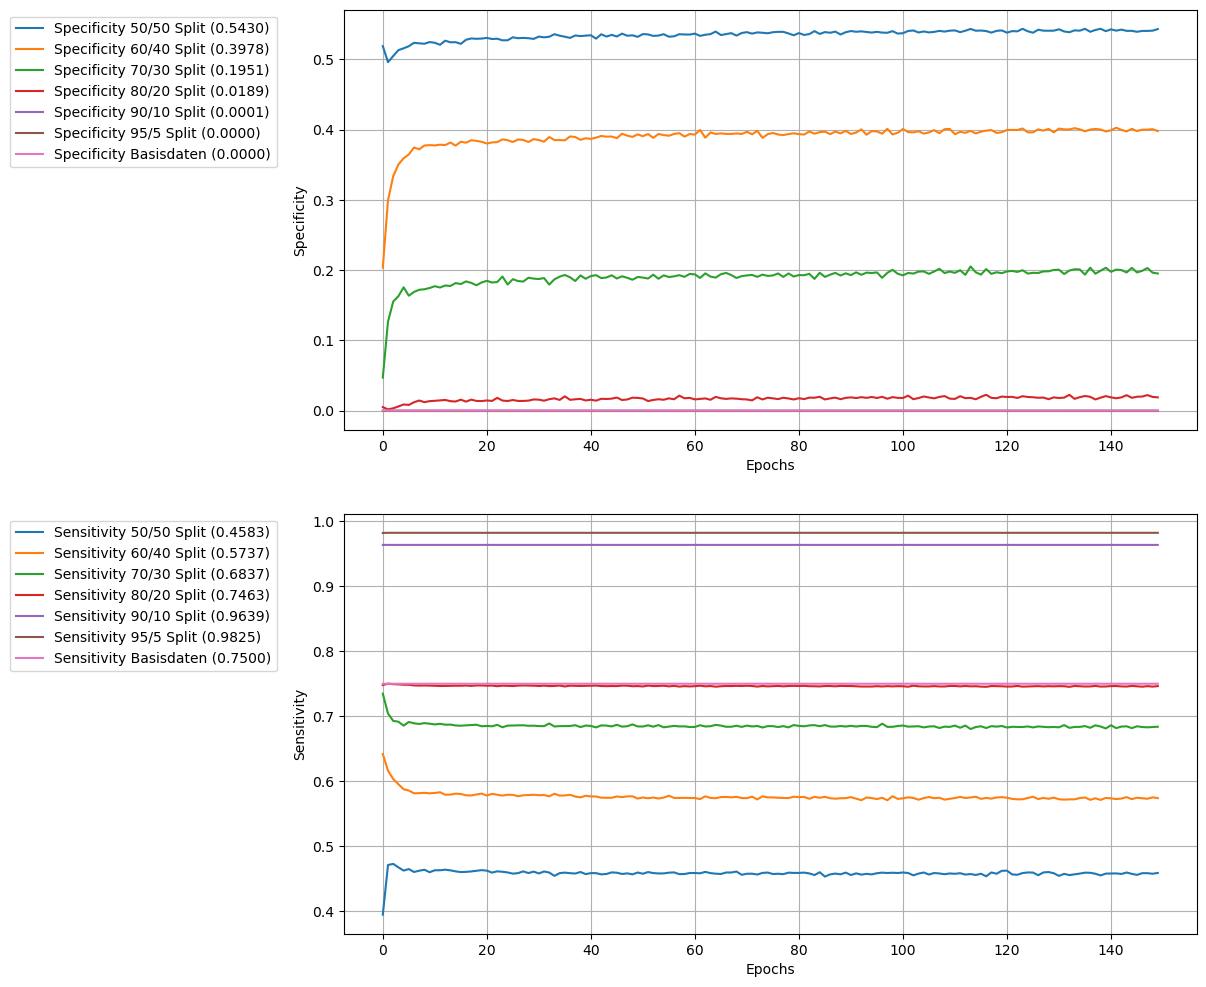

In [77]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(11,12))
        
ax1.plot(specifity_50, label=f'Specificity 50/50 Split ({specifity_50[-1]:.4f})')
ax1.plot(specifity_60, label=f'Specificity 60/40 Split ({specifity_60[-1]:.4f})')
ax1.plot(specifity_70, label=f'Specificity 70/30 Split ({specifity_70[-1]:.4f})')
ax1.plot(specifity_80, label=f'Specificity 80/20 Split ({specifity_80[-1]:.4f})')
ax1.plot(specifity_90, label=f'Specificity 90/10 Split ({specifity_90[-1]:.4f})')
ax1.plot(specifity_95, label=f'Specificity 95/5 Split ({specifity_95[-1]:.4f})')
ax1.plot(specifity_base, label=f'Specificity Basisdaten ({specifity_base[-1]:.4f})')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Specificity')
ax1.grid(zorder = 2)
ax1.legend(bbox_to_anchor=(-0.4, 1), loc='upper left')

ax2.plot(sensivity_50, label=f'Sensitivity 50/50 Split ({sensivity_50[-1]:.4f})')
ax2.plot(sensivity_60, label=f'Sensitivity 60/40 Split ({sensivity_60[-1]:.4f})')
ax2.plot(sensivity_70, label=f'Sensitivity 70/30 Split ({sensivity_70[-1]:.4f})')
ax2.plot(sensivity_80, label=f'Sensitivity 80/20 Split ({sensivity_80[-1]:.4f})')
ax2.plot(sensivity_90, label=f'Sensitivity 90/10 Split ({sensivity_90[-1]:.4f})')
ax2.plot(sensivity_95, label=f'Sensitivity 95/5 Split ({sensivity_95[-1]:.4f})')
ax2.plot(sensivity_base, label=f'Sensitivity Basisdaten ({sensivity_base[-1]:.4f})')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Sensitivity')
ax2.grid(zorder = 2)
ax2.legend(bbox_to_anchor=(-0.4, 1), loc='upper left')

##### 4.2.7 Training mit den Basisdaten mit Split von Frauen und Männern

In [49]:
model_men = base_model(input_dim=8)
model_men.fit(X_train_men, y_train_men, validation_data=(X_val_men, y_val_men), epochs=150)


Epoch 1/150
3341/3341 [==============================] - 4s 1ms/step - loss: 0.2022 - precision: 0.9477 - recall: 1.0000 - val_loss: 0.1946 - val_precision: 0.9493 - val_recall: 1.0000
Epoch 2/150
3341/3341 [==============================] - 3s 1ms/step - loss: 0.1976 - precision: 0.9477 - recall: 1.0000 - val_loss: 0.1935 - val_precision: 0.9493 - val_recall: 1.0000
Epoch 3/150
3341/3341 [==============================] - 4s 1ms/step - loss: 0.1967 - precision: 0.9477 - recall: 1.0000 - val_loss: 0.1931 - val_precision: 0.9493 - val_recall: 1.0000
Epoch 4/150
3341/3341 [==============================] - 3s 999us/step - loss: 0.1964 - precision: 0.9477 - recall: 1.0000 - val_loss: 0.1929 - val_precision: 0.9493 - val_recall: 1.0000
Epoch 5/150
3341/3341 [==============================] - 3s 1ms/step - loss: 0.1962 - precision: 0.9477 - recall: 1.0000 - val_loss: 0.1926 - val_precision: 0.9493 - val_recall: 1.0000
Epoch 6/150
3341/3341 [==============================] - 3s 980us/step -

In [50]:
model_women = base_model(input_dim=8)
model_women.fit(X_train_women, y_train_women, validation_data=(X_val_women, y_val_women), epochs=150)

Epoch 1/150
4043/4043 [==============================] - 4s 1ms/step - loss: 0.1127 - precision: 0.9761 - recall: 1.0000 - val_loss: 0.1036 - val_precision: 0.9774 - val_recall: 1.0000
Epoch 2/150
4043/4043 [==============================] - 4s 997us/step - loss: 0.1076 - precision: 0.9761 - recall: 1.0000 - val_loss: 0.1148 - val_precision: 0.9774 - val_recall: 1.0000
Epoch 3/150
4043/4043 [==============================] - 4s 1ms/step - loss: 0.1071 - precision: 0.9761 - recall: 1.0000 - val_loss: 0.1024 - val_precision: 0.9774 - val_recall: 1.0000
Epoch 4/150
4043/4043 [==============================] - 4s 988us/step - loss: 0.1068 - precision: 0.9761 - recall: 1.0000 - val_loss: 0.1019 - val_precision: 0.9774 - val_recall: 1.0000
Epoch 5/150
4043/4043 [==============================] - 4s 1ms/step - loss: 0.1068 - precision: 0.9761 - recall: 1.0000 - val_loss: 0.1020 - val_precision: 0.9774 - val_recall: 1.0000
Epoch 6/150
4043/4043 [==============================] - 4s 1ms/step - 

#### 4.3 ROC Kurven der Modelle mit unterschiedlichen Splits

4043/4043 [==============================] - 2s 596us/step


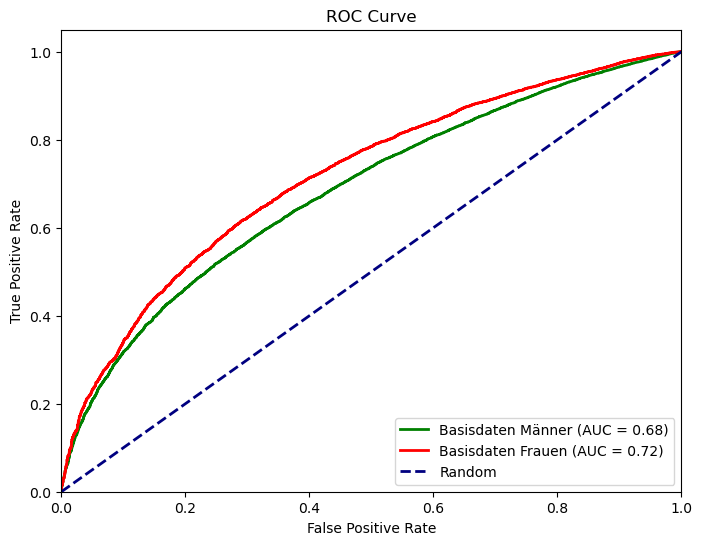

In [52]:
fpr_men, tpr_men, _ = roc_curve(y_train_men, model_men.predict(X_train_men))
fpr_women, tpr_women, _ = roc_curve(y_train_women, model_women.predict(X_train_women))

roc_auc_men = auc(fpr_men, tpr_men)
roc_auc_women = auc(fpr_women, tpr_women)

plt.figure(figsize=(8, 6))
plt.plot(fpr_men, tpr_men, color='green', lw=2, label=f'Basisdaten Männer (AUC = {roc_auc_men:.2f})')
plt.plot(fpr_women, tpr_women, color='red', lw=2, label=f'Basisdaten Frauen (AUC = {roc_auc_women:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()

2461/2461 [==============================] - 2s 738us/step


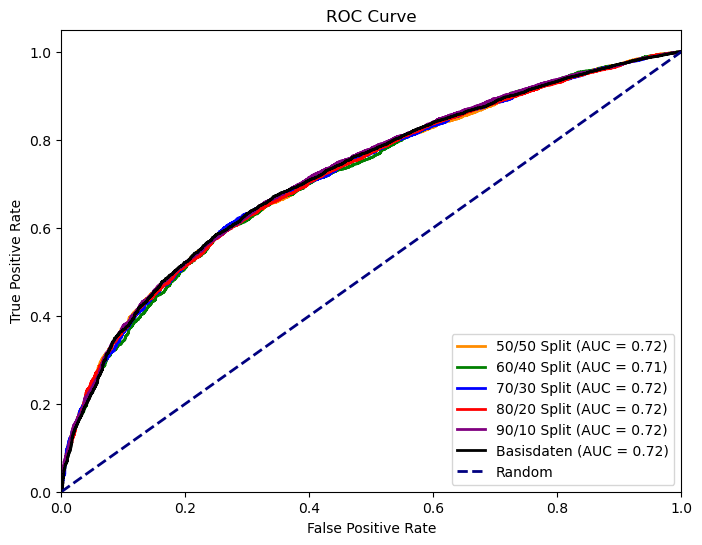

In [121]:
fpr_50, tpr_50, _ = roc_curve(y_test_50, model_50.predict(X_test_50))
fpr_60, tpr_60, _ = roc_curve(y_test_60, model_60.predict(X_test_60))
fpr_70, tpr_70, _ = roc_curve(y_test_70, model_70.predict(X_test_70))
fpr_80, tpr_80, _ = roc_curve(y_test_80, model_80.predict(X_test_80))
fpr_90, tpr_90, _ = roc_curve(y_test_90, model_90.predict(X_test_90))
fpr, tpr, _ = roc_curve(y_test, model_base.predict(X_test))

roc_auc_50 = auc(fpr_50, tpr_50)
roc_auc_60 = auc(fpr_60, tpr_60)
roc_auc_70 = auc(fpr_70, tpr_70)
roc_auc_80 = auc(fpr_80, tpr_80)
roc_auc_90 = auc(fpr_90, tpr_90)
roc_auc_base = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

plt.plot(fpr_50, tpr_50, color='darkorange', lw=2, label=f'50/50 Split (AUC = {roc_auc_50:.2f})')
plt.plot(fpr_60, tpr_60, color='green', lw=2, label=f'60/40 Split (AUC = {roc_auc_60:.2f})')
plt.plot(fpr_70, tpr_70, color='blue', lw=2, label=f'70/30 Split (AUC = {roc_auc_70:.2f})')
plt.plot(fpr_80, tpr_80, color='red', lw=2, label=f'80/20 Split (AUC = {roc_auc_80:.2f})')
plt.plot(fpr_90, tpr_90, color='purple', lw=2, label=f'90/10 Split (AUC = {roc_auc_90:.2f})')
plt.plot(fpr, tpr, color='black', lw=2, label=f'Basisdaten (AUC = {roc_auc_base:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()

2461/2461 [==============================] - 2s 636us/step


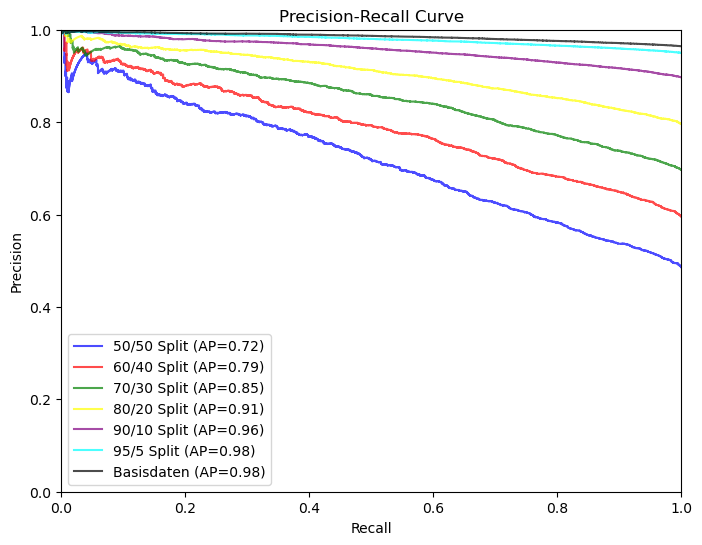

In [126]:
y_scores_50 = model_50.predict(X_test_50)
y_scores_60 = model_60.predict(X_test_60)
y_scores_70 = model_70.predict(X_test_70)
y_scores_80 = model_80.predict(X_test_80)
y_scores_90 = model_90.predict(X_test_90)
y_scores_95 = model_95.predict(X_test_95)
y_scores_base = model_base.predict(X_test)

# Berechne Precision-Recall-Kurve
precision_50, recall_50, thresholds_50 = precision_recall_curve(y_test_50, y_scores_50)
precision_60, recall_60, thresholds_60 = precision_recall_curve(y_test_60, y_scores_60)
precision_70, recall_70, thresholds_70 = precision_recall_curve(y_test_70, y_scores_70)
precision_80, recall_80, thresholds_80 = precision_recall_curve(y_test_80, y_scores_80)
precision_90, recall_90, thresholds_90 = precision_recall_curve(y_test_90, y_scores_90)
precision_95, recall_95, thresholds_95 = precision_recall_curve(y_test_95, y_scores_95)
precision_base, recall_base, thresholds_base = precision_recall_curve(y_test, y_scores_base)

# Berechne den durchschnittlichen Precision Score (Fläche unter der PR-Kurve)
average_precision_50 = average_precision_score(y_test_50, y_scores_50)
average_precision_60 = average_precision_score(y_test_60, y_scores_60)
average_precision_70 = average_precision_score(y_test_70, y_scores_70)
average_precision_80 = average_precision_score(y_test_80, y_scores_80)
average_precision_90 = average_precision_score(y_test_90, y_scores_90)
average_precision_95 = average_precision_score(y_test_95, y_scores_95)
average_precision_base = average_precision_score(y_test, y_scores_base)

# Plot der Precision-Recall-Kurve
plt.figure(figsize=(8, 6))

plt.step(recall_50, precision_50, color='blue', alpha=0.7, where='post', label=f'50/50 Split (AP={average_precision_50:.2f})')
# plt.fill_between(recall_50, precision_50, step='post', alpha=0.3, color='b')

plt.step(recall_60, precision_60, color='red', alpha=0.7, where='post', label=f'60/40 Split (AP={average_precision_60:.2f})')
# plt.fill_between(recall_60, precision_60, step='post', alpha=0.3, color='b')

plt.step(recall_70, precision_70, color='green', alpha=0.7, where='post', label=f'70/30 Split (AP={average_precision_70:.2f})')
# plt.fill_between(recall_70, precision_70, step='post', alpha=0.3, color='b')

plt.step(recall_80, precision_80, color='yellow', alpha=0.7, where='post', label=f'80/20 Split (AP={average_precision_80:.2f})')
# plt.fill_between(recall_80, precision_80, step='post', alpha=0.3, color='b')

plt.step(recall_90, precision_90, color='purple', alpha=0.7, where='post', label=f'90/10 Split (AP={average_precision_90:.2f})')
# plt.fill_between(recall_80, precision_80, step='post', alpha=0.3, color='b')

plt.step(recall_95, precision_95, color='cyan', alpha=0.7, where='post', label=f'95/5 Split (AP={average_precision_95:.2f})')
# plt.fill_between(recall_80, precision_80, step='post', alpha=0.3, color='b')

plt.step(recall_base, precision_base, color='black', alpha=0.7, where='post', label=f'Basisdaten (AP={average_precision_base:.2f})')
# plt.fill_between(recall_80, precision_80, step='post', alpha=0.3, color='b')

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Curve")
plt.legend(loc='lower left')
plt.show()

#### 4.4 Erstellung des Modells mit Hyperparametertuner

In [23]:
def create_base_model(hp):
    
    model = Sequential()
    
    model.add(Dense(64, input_dim=9, activation=tf.nn.relu, kernel_initializer=tf.keras.initializers.he_uniform(seed=42)))
    num_layers = hp.Int("num_layers", min_value=1, max_value=5, step=1)
    
    # Layer, activation, units und Dropoutchoice
    for i in range(num_layers):
        model.add(keras.layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                                     activation=hp.Choice("activation", ["relu", "sigmoid", "leaky_relu", "swish"])))

        use_dropout = hp.Boolean(f'use_dropout_{i}', default=False)
        if use_dropout:
            # Dropout-Layer mit Dropout-Rate als Hyperparameter
            dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.1, default=0.2)
            model.add(keras.layers.Dropout(rate=dropout_rate))
    
    # Optimizer und Learningrate Choice
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop', 'adagrad'])
    
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hp.Float('learning_rate_adam', min_value=1e-4, max_value=1e-1, sampling='LOG', default=1e-3))
    elif optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp.Float('learning_rate_sgd', min_value=1e-4, max_value=1e-1, sampling='LOG', default=1e-2))
    elif optimizer_choice == "adagrad":
        optimizer = keras.optimizers.Adagrad(learning_rate=hp.Float('learning_rate_adagrad', min_value=1e-4, max_value=1e-1, sampling='LOG', default=1e-2))
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=hp.Float('learning_rate_rmsprop', min_value=1e-4, max_value=1e-1, sampling='LOG', default=1e-3))
    
    
    model.add(keras.layers.Dense(units=1, activation='sigmoid'))
    
    metrics=[keras.metrics.TruePositives(name="truepositives"),
             keras.metrics.TrueNegatives(name="truenegatives")]
    
    model.compile(loss = "BinaryCrossentropy", optimizer = optimizer, metrics = metrics)
    return model

#### 4.5 Erstellung der Hyperparametertuner

Diese Tuner sollen die möglichst besten Hyperparameter finden. Hierbei wurden GridSearch und RandomSearch verwendet.

##### 4.5.1 GridSearch

In [29]:
tuner = GridSearch(
    create_base_model,
    objective=[Objective("truepositives", "max"), Objective("truenegatives", "max"), Objective("val_truepositives", "max"), Objective("val_truenegatives", "max")],
    max_trials=100,
    directory="/my_tuning_directory8/",
    project_name='my_tuning_project'
)

In [30]:
tuner.search(x=X_train, y=y_train, epochs=100, validation_data=(X_val, y_val), batch_size=180)

Trial 20 Complete [00h 02m 09s]
multi_objective: -303486.0

Best multi_objective So Far: -303489.0
Total elapsed time: 00h 44m 36s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
1                 |1                 |num_layers
32                |32                |units_0
relu              |relu              |activation
False             |False             |use_dropout_0
sgd               |adam              |optimizer
0.001             |0.0022387         |learning_rate_adam
0.0044668         |None              |learning_rate_sgd

Epoch 1/100
1313/1313 [==============================] - 2s 1ms/step - loss: 0.1796 - truepositives: 226748.0000 - truenegatives: 37.0000 - val_loss: 0.1574 - val_truepositives: 75884.0000 - val_truenegatives: 0.0000e+00
Epoch 2/100
1313/1313 [==============================] - 1s 1ms/step - loss: 0.1574 - truepositives: 227602.0000 - truenegatives: 0.0000e+00 - val_loss: 0.1555 - val_truepositives: 75884.0000 - val_truenegativ

KeyboardInterrupt: 

In [33]:
best_hps = tuner.get_best_hyperparameters(5)
model = create_base_model(best_hps[0])
x_all = np.concatenate((X_train, X_val))
y_all = np.concatenate((y_train, y_val))
model.fit(x=x_all, y=y_all, epochs=150, batch_size = 180)

Epoch 1/150
1750/1750 [==============================] - 2s 781us/step - loss: 0.1496 - truepositives: 303215.0000 - truenegatives: 12.0000
Epoch 2/150
1750/1750 [==============================] - 1s 792us/step - loss: 0.1464 - truepositives: 303486.0000 - truenegatives: 0.0000e+00
Epoch 3/150
1750/1750 [==============================] - 1s 764us/step - loss: 0.1464 - truepositives: 303486.0000 - truenegatives: 0.0000e+00
Epoch 4/150
1750/1750 [==============================] - 1s 772us/step - loss: 0.1461 - truepositives: 303486.0000 - truenegatives: 0.0000e+00
Epoch 5/150
1750/1750 [==============================] - 1s 775us/step - loss: 0.1460 - truepositives: 303486.0000 - truenegatives: 0.0000e+00
Epoch 6/150
1750/1750 [==============================] - 1s 791us/step - loss: 0.1459 - truepositives: 303486.0000 - truenegatives: 0.0000e+00
Epoch 7/150
1750/1750 [==============================] - 1s 783us/step - loss: 0.1459 - truepositives: 303486.0000 - truenegatives: 0.0000e+00
Ep

In [34]:
model.save('my_model3.keras')

In [147]:
model.evaluate(X_test_50, y_test_50)

179/179 [==============================] - 0s 815us/step - loss: 0.6154 - truepositives: 1738.0000 - truenegatives: 2064.0000


[0.6153786182403564, 1738.0, 2064.0]

##### 4.5.2 RandomSearch

In [37]:
tuner2 = RandomSearch(
    create_base_model,
    objective=[Objective("truepositives", "max"), Objective("truenegatives", "max"), Objective("val_truepositives", "max"), Objective("val_truenegatives", "max")],
    max_trials=20,
    directory="/my_tuning_directory9/",
    project_name='my_tuning_project'
)

In [38]:
tuner2.search(x=X_train, y=y_train, epochs=100, validation_data=(X_val, y_val), batch_size=180)

Trial 20 Complete [00h 09m 06s]
multi_objective: -303486.0

Best multi_objective So Far: -303489.0
Total elapsed time: 01h 53m 47s


In [39]:
best_hps = tuner2.get_best_hyperparameters(5)
model = create_base_model(best_hps[0])
x_all = np.concatenate((X_train_50, X_val_50))
y_all = np.concatenate((y_train_50, y_val_50))
model.fit(x=x_all, y=y_all, epochs=150)

Epoch 1/150
716/716 [==============================] - 1s 1ms/step - loss: 0.6286 - truepositives: 6981.0000 - truenegatives: 7830.0000
Epoch 2/150
716/716 [==============================] - 1s 1ms/step - loss: 0.6199 - truepositives: 6886.0000 - truenegatives: 8168.0000
Epoch 3/150
716/716 [==============================] - 1s 1ms/step - loss: 0.6182 - truepositives: 6946.0000 - truenegatives: 8120.0000
Epoch 4/150
716/716 [==============================] - 1s 1ms/step - loss: 0.6172 - truepositives: 6969.0000 - truenegatives: 8126.0000
Epoch 5/150
716/716 [==============================] - 1s 1ms/step - loss: 0.6155 - truepositives: 7009.0000 - truenegatives: 8153.0000
Epoch 6/150
716/716 [==============================] - 1s 1ms/step - loss: 0.6149 - truepositives: 6986.0000 - truenegatives: 8178.0000
Epoch 7/150
716/716 [==============================] - 1s 1ms/step - loss: 0.6141 - truepositives: 7001.0000 - truenegatives: 8143.0000
Epoch 8/150
716/716 [===========================

In [40]:
model.save("randomsearch3.keras")

In [41]:
random_search_model = tf.keras.models.load_model('randomsearch2.keras')
random_search_model2 = tf.keras.models.load_model('randomsearch.keras')
random_search_model3 = tf.keras.models.load_model('randomsearch3.keras')
grid_search_model = tf.keras.models.load_model('my_model.keras')
grid_search_model2 = tf.keras.models.load_model('my_model2.keras')
grid_search_model3 = tf.keras.models.load_model("my_model3.keras")

### 5 ROC Kurve

2461/2461 [==============================] - 1s 586us/step


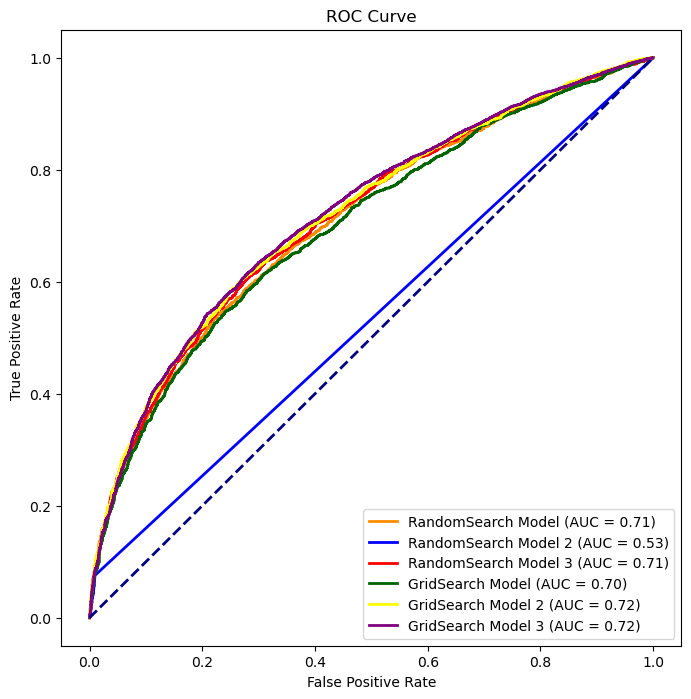

In [42]:
y_pred = random_search_model.predict(X_test_50)
y_pred2 = random_search_model2.predict(X_test_50)
y_pred3 = random_search_model3.predict(X_test_50)
y_pred4 = grid_search_model.predict(X_test_50)
y_pred5 = grid_search_model2.predict(X_test_50)
y_pred6 = grid_search_model2.predict(X_test)

fpr, tpr, _ = roc_curve(y_test_50, y_pred)
fpr2, tpr2, _ = roc_curve(y_test_50, y_pred2)
fpr3, tpr3, _ = roc_curve(y_test_50, y_pred3)
fpr4, tpr4, _ = roc_curve(y_test_50, y_pred4)
fpr5, tpr5, _ = roc_curve(y_test_50, y_pred5)
fpr6, tpr6, _ = roc_curve(y_test, y_pred6)

roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr2,tpr2)
roc_auc3 = auc(fpr3,tpr3)
roc_auc4 = auc(fpr4,tpr4)
roc_auc5 = auc(fpr5,tpr5)
roc_auc6 = auc(fpr6,tpr6)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='RandomSearch Model (AUC = {:.2f})'.format(roc_auc))
plt.plot(fpr2, tpr2, color='blue', lw=2, label='RandomSearch Model 2 (AUC = {:.2f})'.format(roc_auc2))
plt.plot(fpr3, tpr3, color='red', lw=2, label='RandomSearch Model 3 (AUC = {:.2f})'.format(roc_auc3))
plt.plot(fpr4, tpr4, color='darkgreen', lw=2, label='GridSearch Model (AUC = {:.2f})'.format(roc_auc4))
plt.plot(fpr5, tpr5, color='yellow', lw=2, label='GridSearch Model 2 (AUC = {:.2f})'.format(roc_auc5))
plt.plot(fpr6, tpr6, color='purple', lw=2, label='GridSearch Model 3 (AUC = {:.2f})'.format(roc_auc6))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()